In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import pickle

In [2]:
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [3]:
#x = pd.read_csv('../data/my-in-hospital-mortality2/train/3_episode1_timeseries.csv')
x = pd.read_csv('./data/mingjie-mortality/train/3_episode1_timeseries.csv')
print(x.head(5))

   Unnamed: 0     Hours  Albumin  Bicarbonate  Bilirubin  Blood urea nitrogen  \
0           0 -2.503056      NaN         25.0        NaN                 53.0   
1           1 -1.203056      NaN          NaN        NaN                  NaN   
2           2 -1.169722      NaN          NaN        NaN                  NaN   
3           3 -0.669722      NaN          NaN        NaN                  NaN   
4           4 -0.419722      NaN          NaN        NaN                  NaN   

   CO2  Calcium  Calcium ionized  Capillary refill rate ...   Platelets  \
0  NaN      8.2              NaN                    NaN ...       282.0   
1  NaN      NaN              NaN                    NaN ...         NaN   
2  NaN      NaN              NaN                    NaN ...         NaN   
3  NaN      NaN              NaN                    NaN ...         NaN   
4  NaN      NaN              NaN                    NaN ...         NaN   

   Potassium  Prothrombin time  Respiratory rate  Systolic blo

In [4]:
def plot_scatter_sim(x, y):
    plt.figure()
    plt.scatter(x, y)
    plt.grid(True)
    plt.show()

def plot_hist_simple(data):
    plt.figure()
    plt.hist(data)
    plt.grid(True)
    plt.show()
    

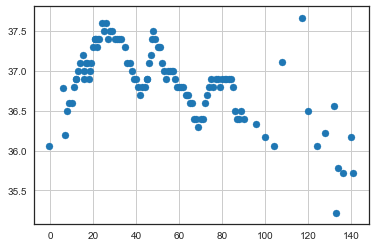

In [5]:
plot_scatter_sim(x['Hours'], x['Temperature'])

In [6]:
train_list_df = pd.read_csv('./data/mingjie-mortality/train/listfile.csv')
test_list_df = pd.read_csv('./data/mingjie-mortality/test/listfile.csv')
print(test_list_df.head(5))

   Unnamed: 0        Age Deathtime  Ethnicity                       Filename  \
0        5999  51.582928       NaN          4  11850_episode1_timeseries.csv   
1        4927  71.400858       NaN          4  22068_episode1_timeseries.csv   
2        3628  64.703971       NaN          4    975_episode1_timeseries.csv   
3         590  56.487507       NaN          4  68184_episode1_timeseries.csv   
4        2143  41.312152       NaN          4  28317_episode1_timeseries.csv   

   Gender  Height  Icustay               Intime  Length of Stay  Mortality  \
0       2     NaN   299951  2193-08-28 18:27:00         70.6176          0   
1       1     NaN   299941  2178-09-19 07:30:47         34.0800          0   
2       2     NaN   299931  2139-01-12 22:47:16         65.0232          0   
3       2   170.0   299929  2145-01-14 22:33:54         43.1040          0   
4       1     NaN   299917  2151-06-28 22:27:19         43.5960          0   

               Outtime  Real Death Hours     Weigh

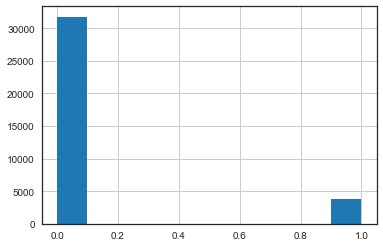

In [7]:
plot_hist_simple(train_list_df['Mortality'])

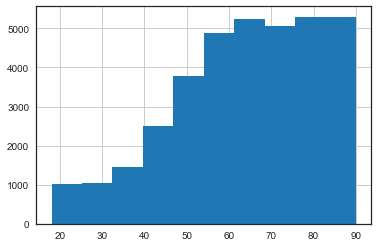

In [8]:
plot_hist_simple(train_list_df['Age'])

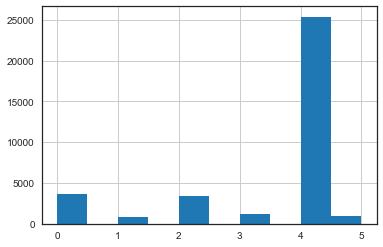

In [9]:
plot_hist_simple(train_list_df['Ethnicity'])

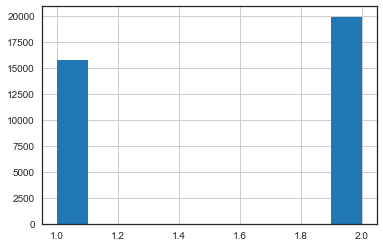

In [10]:
plot_hist_simple(train_list_df['Gender'])

In [11]:
train_list_df['Height'].describe()

count    7963.000000
mean      168.665541
std        15.366249
min         0.000000
25%       161.000000
50%       170.000000
75%       178.000000
max       445.000000
Name: Height, dtype: float64

In [12]:
train_list_df['Weight'].describe()

count    28976.000000
mean        82.025109
std         53.476795
min          0.000000
25%         65.680122
50%         78.317671
75%         93.395945
max       8088.996854
Name: Weight, dtype: float64

In [23]:
import time
from datetime import datetime as dt
import pandas as pd

def get_diff_time_by_hours(time1, time2):
    '''
    time1: '2018-02-11 16:33:43'
    time2: '2018-02-12 16:33:43'
    '''
    # Handle '2123-04-13' does not match format '%Y-%m-%d %H:%M:%S'
    if len(time1) == 10:
        time1 += ' 00:00:00'
    if len(time2) == 10:
        time2 += ' 00:00:00'

    a = dt.strptime(time1, '%Y-%m-%d %H:%M:%S')
    b = dt.strptime(time2, '%Y-%m-%d %H:%M:%S')

    diff = b - a
    hours = diff.days * 24
    hours += diff.seconds / 3600.
    return hours

def get_sparse_coding_from_dataset(data_dir='./data/mingjie-mortality/',
                                   mode='train',
                                   max_encounters=-1,
                                   max_hours=72):
    list_df = pd.read_csv('{}/{}/listfile.csv'.format(data_dir, mode))

    Ts = []
    Ys = []
    ind_ts = []
    ind_fs = []

    if max_encounters == -1:
        max_encounters = len(list_df)

    for i in range(max_encounters):
        T = []
        Y = []
        ind_t = []
        ind_f = []

        start_time = time.time()

        filename = list_df.iloc[i]['Filename']
        intime = list_df.iloc[i]['Intime']
        deathtime = list_df.iloc[i]['Deathtime']
        outtime = list_df.iloc[i]['Outtime']

        rel_end_time = get_diff_time_by_hours(intime, outtime)

        if pd.notnull(deathtime):
            rel_deathtime = get_diff_time_by_hours(intime, deathtime)
            rel_end_time = min(rel_deathtime, rel_end_time)

        measurements = pd.read_csv('{}/{}/{}'.format(
            data_dir, mode, filename
        ))

        # Take the end time and its max_hours hours before. Use the min(outtime, deathtime)
        measurements = measurements[(measurements['Hours'] >= 0) &
                                    (measurements['Hours'] <= rel_end_time)]
        T = measurements['Hours'].tolist()
        for j, j_name in enumerate(list(measurements)[2:]):
            valid_measurements = measurements[pd.notnull(measurements[j_name])]
            if len(valid_measurements) > 0:
                Y += valid_measurements[j_name].tolist()
                ind_f += [j] * len(valid_measurements)
                ind_t += valid_measurements.index.tolist()

        if len(ind_t) > 0:
            Ts.append(T)
            Ys.append(Y)
            ind_ts.append(ind_t)
            ind_fs.append(ind_f)

        if i % 1000 == 0:
            print('Finished {} / {}. Take {}s'.format(
                i, len(list_df), time.time() - start_time))
    return Ts, Ys, ind_ts, ind_fs


In [24]:
train_Ts, train_Ys, train_ind_ts, train_ind_fs = get_sparse_coding_from_dataset(mode='train', 
                                                                                max_encounters=1000)

Finished 0 / 35588. Take 0.04234123229980469s


In [26]:
test_Ts, test_Ys, test_ind_ts, test_ind_fs = get_sparse_coding_from_dataset(mode='test',
                                                                            max_encounters=1000)

Finished 0 / 6274. Take 0.03727889060974121s


## Get Time invariant features

In [ ]:
def get_time_invariant_variables(mode):
    return

## Load labels

In [74]:
import pandas as pd

def get_labels_and_end_time(mode='train'):
    train_df = pd.read_csv('../data/my-in-hospital-mortality2/%s/listfile.csv' % mode)
    train_labels = train_df['mortality'].values
    print(train_labels.shape)

    train_rel_end_time = []
    for i in range(train_df.shape[0]):
        intime = train_df.iloc[i]['intime']
        deathtime = train_df.iloc[i]['deathtime']
        outtime = train_df.iloc[i]['outtime']

        rel_end_time = get_diff_time_by_hours(intime, outtime)

        if not pd.isna(deathtime):
            rel_deathtime = get_diff_time_by_hours(intime, deathtime)
            rel_end_time = min(rel_deathtime, rel_end_time)

        train_rel_end_time.append(rel_end_time)
    return train_labels, train_rel_end_time


train_labels, train_rel_end_time = get_labels_and_end_time('train')
test_labels, test_rel_end_time = get_labels_and_end_time('test')

(35725,)
(6294,)


In [75]:
import pickle
pickle.dump((train_Ts, train_Ys, train_ind_ts, train_ind_fs, train_labels, train_rel_end_time), 
            open('../data/my-in-hospital-mortality2/train_unscaled.pkl', 'wb'))
pickle.dump((test_Ts, test_Ys, test_ind_ts, test_ind_fs, test_labels, test_rel_end_time),  
            open('../data/my-in-hospital-mortality2/test_unscaled.pkl', 'wb'))

In [133]:
import pickle
train_Ts, train_Ys, train_ind_ts, train_ind_fs, train_labels, train_rel_end_time = \
    pickle.load(open('../data/my-in-hospital-mortality2/train_unscaled.pkl', 'rb'))
test_Ts, test_Ys, test_ind_ts, test_ind_fs, test_labels, test_rel_end_time = \
    pickle.load(open('../data/my-in-hospital-mortality2/test_unscaled.pkl', 'rb'))

## Normalize them

In [6]:
x[['Hours', 'Urine output']].describe()

,Hours,Urine output
count,254.000000,106.000000
mean,62.184149,142.943396
std,48.830007,127.145798
min,-2.503056,5.000000
25%,20.730278,60.000000
50%,54.330278,100.000000
75%,97.580278,180.000000
max,249.746944,600.000000


In [134]:
log_fields = ['Blood urea nitrogen', 'Creatinine', 'Urine output',
              'Red blood cell count', 'White blood cell count', 'Platelets',
              'Albumin', 'Bicarbonate', 'Bilirubin', 'Phosphate']
binary_fields = ['Capillary refill rate']

norm_fields = [
   'Chloride', 'Cholesterol',
   'Diastolic blood pressure', 'Fraction inspired oxygen',
   'Glascow coma scale total', 'Glucose', 'Heart Rate',
   'Mean blood pressure', 'Oxygen saturation',
   'Partial pressure of oxygen', 'Potassium',
   'Respiratory rate', 'Sodium',
   'Systolic blood pressure', 'Temperature', 'Troponin-T', 
   'Weight', 'pH']

In [135]:
x.columns

Index(['Hours', 'Albumin', 'Bicarbonate', 'Bilirubin', 'Blood urea nitrogen',
       'Capillary refill rate', 'Chloride', 'Cholesterol', 'Creatinine',
       'Diastolic blood pressure', 'Fraction inspired oxygen',
       'Glascow coma scale total', 'Glucose', 'Heart Rate',
       'Mean blood pressure', 'Oxygen saturation',
       'Partial pressure of oxygen', 'Phosphate', 'Platelets', 'Potassium',
       'Red blood cell count', 'Respiratory rate', 'Sodium',
       'Systolic blood pressure', 'Temperature', 'Troponin-T', 'Urine output',
       'Weight', 'White blood cell count', 'pH'],
      dtype='object')

In [136]:
idx_to_feature_name = dict([(idx, name) for idx, name in enumerate(x.columns[1:])])

aggregators = dict([(name, []) for name in (norm_fields + log_fields)])

In [137]:
# sum all the fields together. Get the summary statistics, then convert them again.
for Y, T, ind_f, ind_t in zip(train_Ys + test_Ys, train_Ts + test_Ts, 
                              train_ind_fs + test_ind_fs, train_ind_ts + test_ind_ts):
    for idx, (y, f) in enumerate(zip(Y, ind_f)):
        if y < 0: # Should not have negative value
            continue
        
        feature_name = idx_to_feature_name[f]
        
        if feature_name in log_fields:
            y = np.log(0.1 + y)
        
        # Exclude thise with binary fields
        if feature_name not in aggregators:
            continue
        
        aggregators[feature_name].append(y)

## Remove outliers by IQR. Then normalize by 0 mean 1 var

In [138]:
upperbound_dict = {}
lowerbound_dict = {}
mean_dict = {}
std_dict = {}
for k in aggregators:
    tmp = np.array(aggregators[k])
    
    IQR = np.percentile(tmp, 75) - np.percentile(tmp, 25)
    median = np.percentile(tmp, 50)
    
    upperbound_dict[k] = median + 4.5 * IQR
    lowerbound_dict[k] = median - 4.5 * IQR
    
    tmp = tmp[tmp < upperbound_dict[k]]
    tmp = tmp[tmp > lowerbound_dict[k]]
    
    mean_dict[k] = np.mean(tmp)
    std_dict[k] = np.std(tmp)

## Visualize the histogram

Chloride


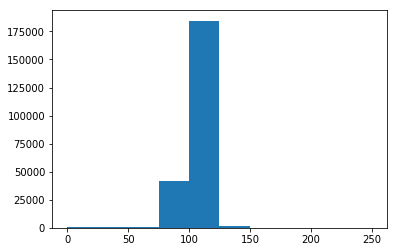

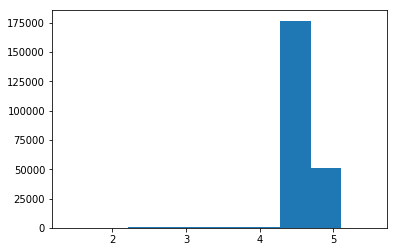

Cholesterol


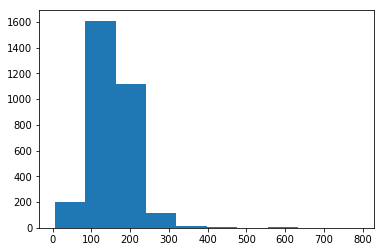

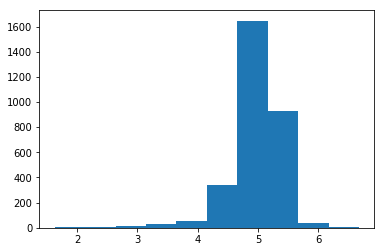

Diastolic blood pressure


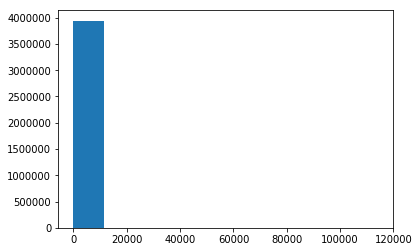

%s has negative value!


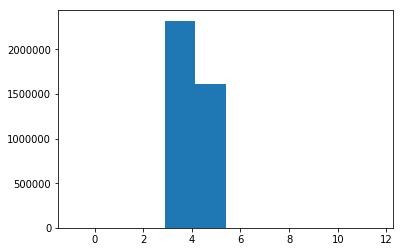

Fraction inspired oxygen


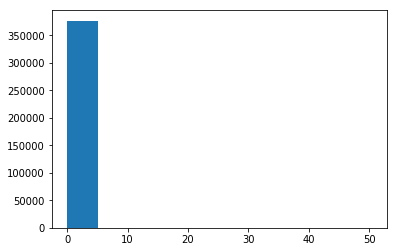

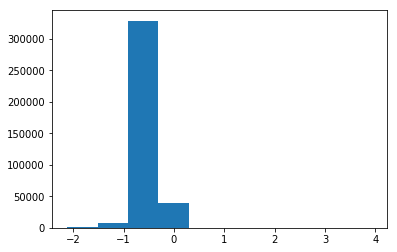

Glascow coma scale total


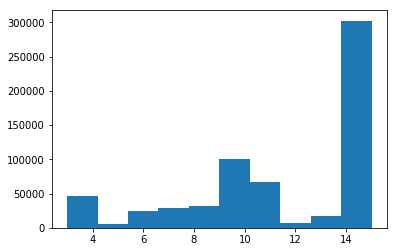

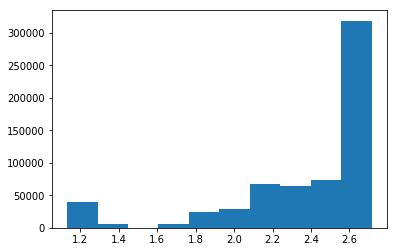

Glucose


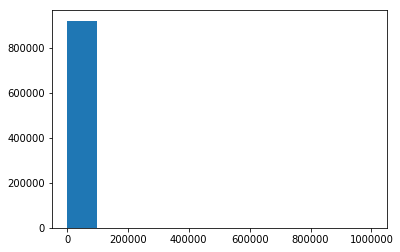

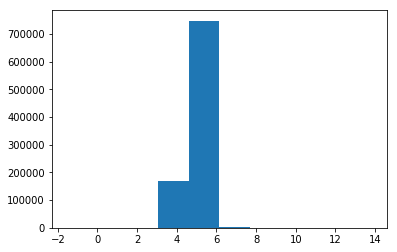

Heart Rate


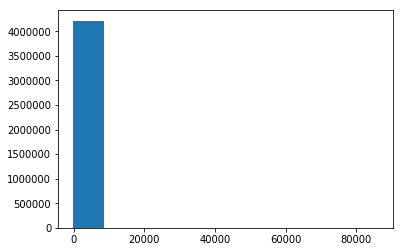

%s has negative value!


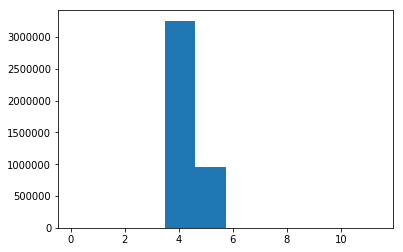

Mean blood pressure


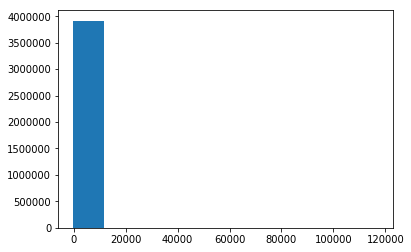

%s has negative value!


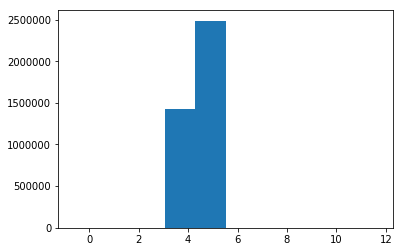

Oxygen saturation


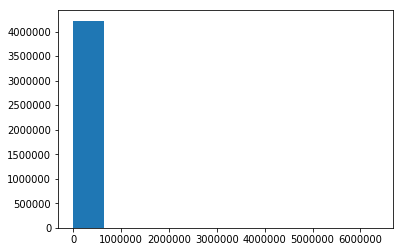

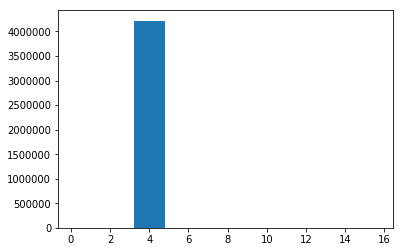

Partial pressure of oxygen


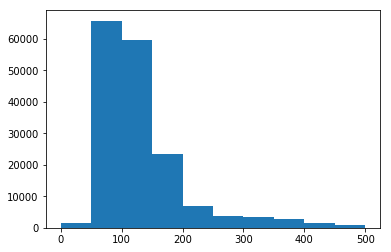

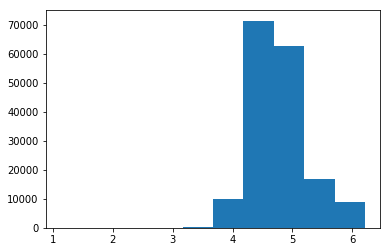

Potassium


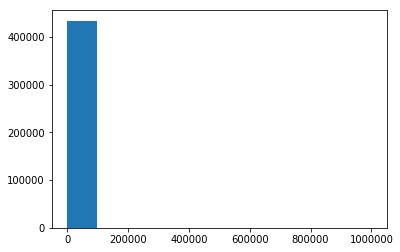

%s has negative value!


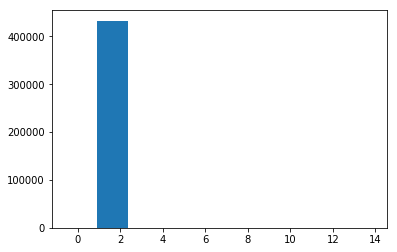

Respiratory rate


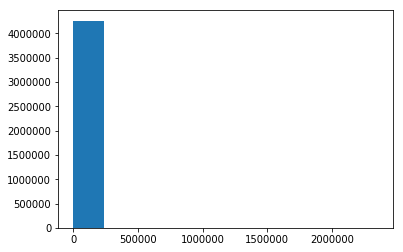

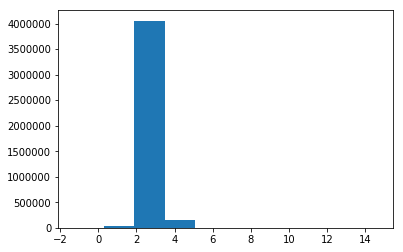

Sodium


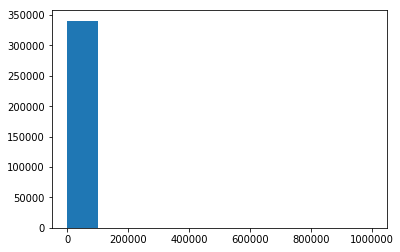

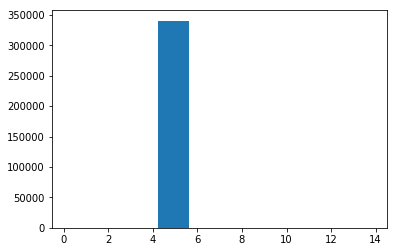

Systolic blood pressure


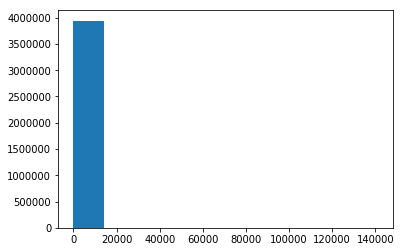

%s has negative value!


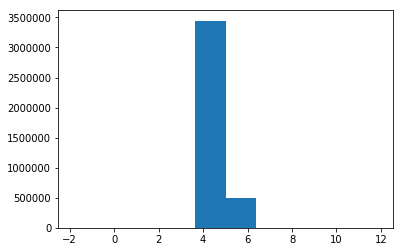

Temperature


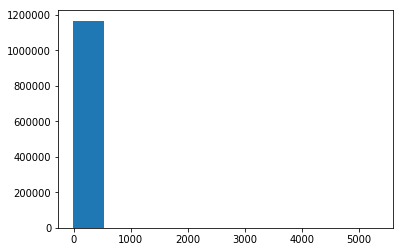

%s has negative value!


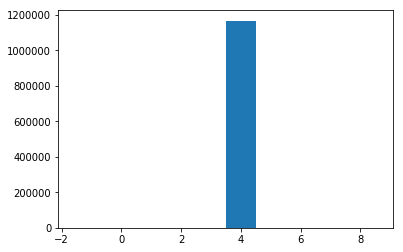

Troponin-T


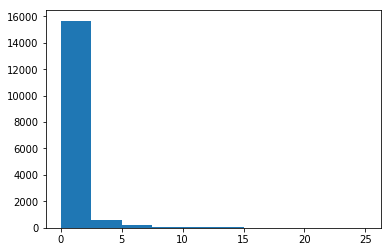

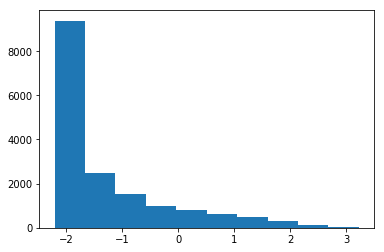

Weight


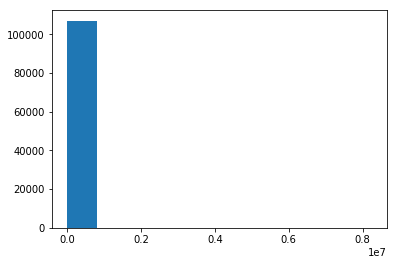

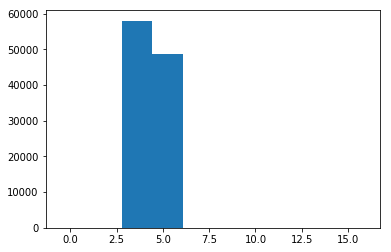

pH


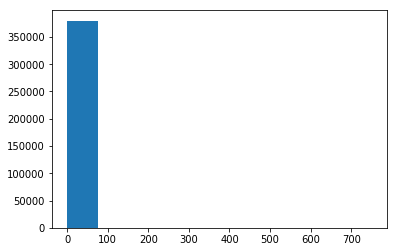

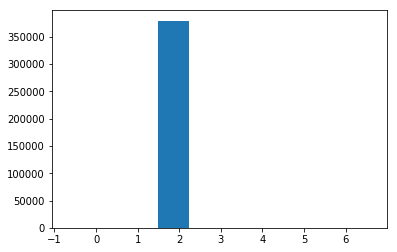

Blood urea nitrogen


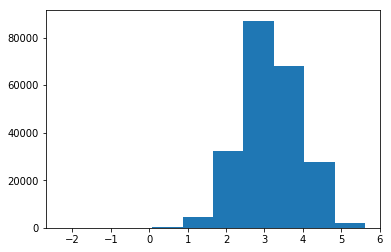

%s has negative value!


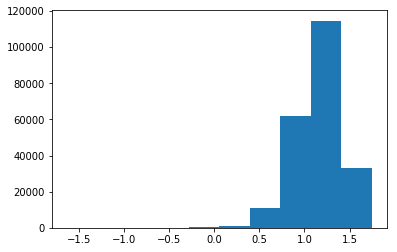

Creatinine


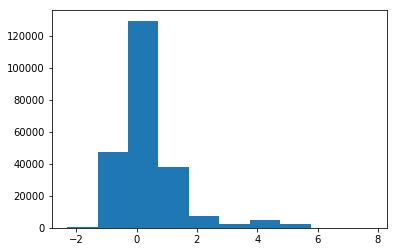

%s has negative value!


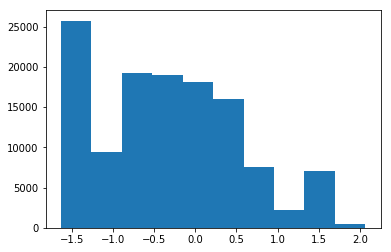

Urine output


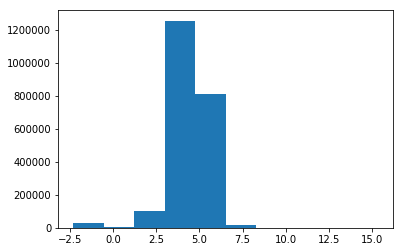

%s has negative value!


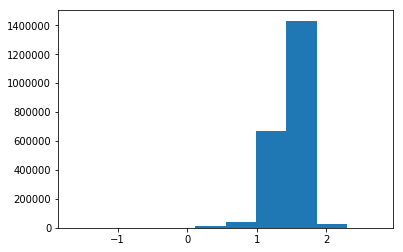

Red blood cell count


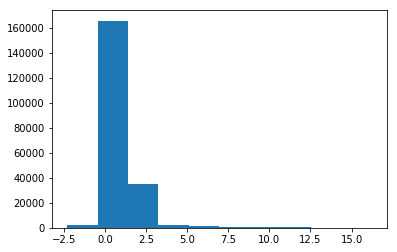

%s has negative value!


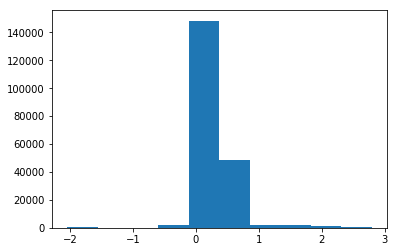

White blood cell count


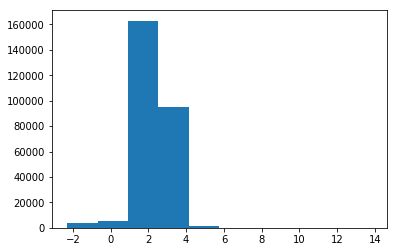

%s has negative value!


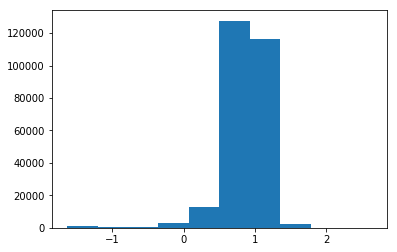

Platelets


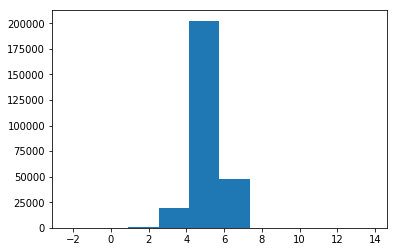

%s has negative value!


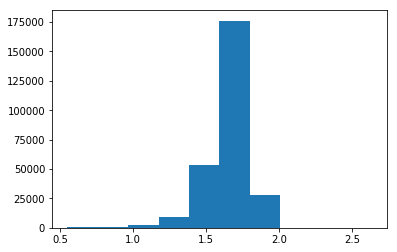

Albumin


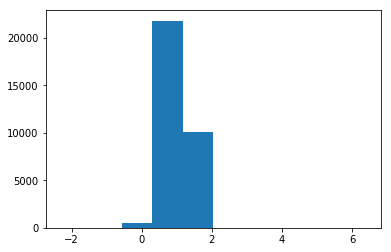

%s has negative value!


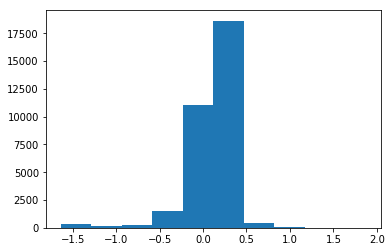

Bicarbonate


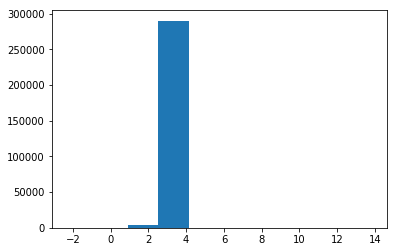

%s has negative value!


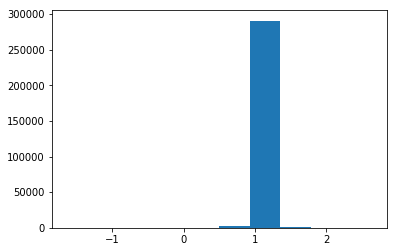

Bilirubin


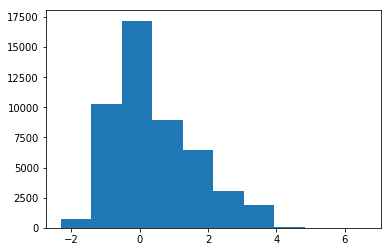

%s has negative value!


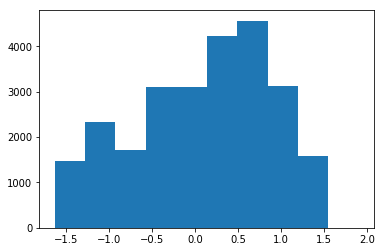

Phosphate


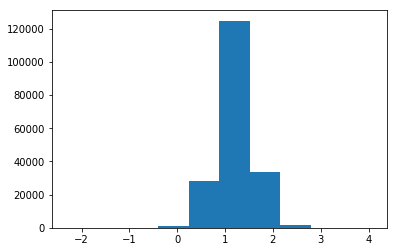

%s has negative value!


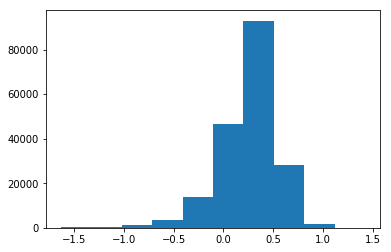

In [109]:
for k in aggregators:
    print(k)
    tmp = np.array(aggregators[k])
    plt.hist(tmp)
    plt.show()
    
    if np.sum(tmp < 0) != 0:
        print('%s has negative value!')
    
    tmp = tmp[tmp > 0]
    tmp = np.log(0.1 + tmp)
    plt.hist(tmp)
    plt.show()

In [126]:
mean_dict

{'Albumin': 1.0515424655752159,
 'Bicarbonate': 3.2004959174866681,
 'Bilirubin': 0.40124790082173156,
 'Blood urea nitrogen': 3.1594098983327994,
 'Chloride': 104.92471137149901,
 'Cholesterol': 152.81994096425058,
 'Creatinine': 0.21695980131929912,
 'Diastolic blood pressure': 60.670583191181521,
 'Fraction inspired oxygen': 0.44863846034317106,
 'Glascow coma scale total': 11.532432750322659,
 'Glucose': 135.44259887646206,
 'Heart Rate': 86.417694204288765,
 'Mean blood pressure': 79.234100192639346,
 'Oxygen saturation': 97.290544596286409,
 'Partial pressure of oxygen': 118.94487108347094,
 'Phosphate': 1.2358267797765521,
 'Platelets': 5.1955209300384864,
 'Potassium': 4.0802115976309246,
 'Red blood cell count': 1.2400382409394937,
 'Respiratory rate': 19.829880000122689,
 'Sodium': 138.8946910770089,
 'Systolic blood pressure': 122.21601963846369,
 'Temperature': 37.018660361281519,
 'Troponin-T': 0.12402611759828647,
 'Urine output': 4.4253984917642821,
 'Weight': 82.7346205

In [125]:
std_dict

{'Albumin': 0.23684453844299849,
 'Bicarbonate': 0.20124514534911031,
 'Bilirubin': 1.2334836330116226,
 'Blood urea nitrogen': 0.74150940760134743,
 'Chloride': 6.3426334321505209,
 'Cholesterol': 49.196642752467675,
 'Creatinine': 0.66462986378977729,
 'Diastolic blood pressure': 14.140147907186149,
 'Fraction inspired oxygen': 0.070970122373671951,
 'Glascow coma scale total': 3.7810058723682332,
 'Glucose': 42.546324984738497,
 'Heart Rate': 18.083142536098457,
 'Mean blood pressure': 15.64107442836664,
 'Oxygen saturation': 2.4064486129295948,
 'Partial pressure of oxygen': 47.759102654315271,
 'Phosphate': 0.34959802792373962,
 'Platelets': 0.64753115435994046,
 'Potassium': 0.57676262147875224,
 'Red blood cell count': 0.17175645113927757,
 'Respiratory rate': 6.2139608016555732,
 'Sodium': 4.9243704022695356,
 'Systolic blood pressure': 23.545112755908917,
 'Temperature': 0.81943905599429712,
 'Troponin-T': 0.18721664567956717,
 'Urine output': 0.93148458046356786,
 'Weight': 2

In [117]:
upperbound_dict

{'Albumin': 1.6796801364883494,
 'Bicarbonate': 3.7032517817697244,
 'Bilirubin': 3.5048063642811753,
 'Blood urea nitrogen': 5.179727956742143,
 'Chloride': 121.0,
 'Cholesterol': 278.0,
 'Creatinine': 1.8253050547775342,
 'Diastolic blood pressure': 95.0,
 'Fraction inspired oxygen': 0.59999999999999998,
 'Glascow coma scale total': 25.0,
 'Glucose': 235.0,
 'Heart Rate': 135.0,
 'Mean blood pressure': 120.0,
 'Oxygen saturation': 104.0,
 'Partial pressure of oxygen': 239.0,
 'Phosphate': 2.034705647838444,
 'Platelets': 6.8521477046973231,
 'Potassium': 5.4000000000000004,
 'Red blood cell count': 1.7068795073488765,
 'Respiratory rate': 35.0,
 'Sodium': 151.0,
 'Systolic blood pressure': 184.0,
 'Temperature': 39.111111111111128,
 'Troponin-T': 0.6399999999999999,
 'Urine output': 7.007827099860247,
 'Weight': 138.81820785175779,
 'White blood cell count': 3.6528548053865086,
 'pH': 7.6100000000000003}

In [118]:
lowerbound_dict

{'Albumin': 0.44974133749650713,
 'Bicarbonate': 2.7424839105057526,
 'Bilirubin': -3.3141860046725258,
 'Blood urea nitrogen': 1.099937278313353,
 'Chloride': 89.0,
 'Cholesterol': 26.0,
 'Creatinine': -1.6346846951688843,
 'Diastolic blood pressure': 23.0,
 'Fraction inspired oxygen': 0.20000000000000007,
 'Glascow coma scale total': 1.0,
 'Glucose': 23.0,
 'Heart Rate': 35.0,
 'Mean blood pressure': 36.0,
 'Oxygen saturation': 92.0,
 'Partial pressure of oxygen': -17.0,
 'Phosphate': 0.41284521540578734,
 'Platelets': 3.6534459977951315,
 'Potassium': 2.5999999999999996,
 'Red blood cell count': 0.77565767079038928,
 'Respiratory rate': 3.0,
 'Sodium': 127.0,
 'Systolic blood pressure': 56.0,
 'Temperature': 34.888888888888872,
 'Troponin-T': -0.52000000000000002,
 'Urine output': 1.7587246082883805,
 'Weight': 21.781798251757834,
 'White blood cell count': 1.0688531968495343,
 'pH': 7.169999999999999}

In [139]:
# Normalize it
def normalize(train_Ys, train_Ts, train_ind_fs, train_ind_ts):
    new_train_Ys = []
    new_train_Ts = []
    new_train_ind_fs = []
    new_train_ind_ts = []

    for Y, T, ind_f, ind_t in zip(train_Ys, train_Ts, train_ind_fs, train_ind_ts):
        new_Y = []
        new_T = []
        new_ind_f = []
        new_ind_t = []
        for idx, (theY, theT, the_ind_f, the_ind_t) in enumerate(zip(Y, T, ind_f, ind_t)):
            if theY < 0:
                continue
            feature_name = idx_to_feature_name[f]

            if feature_name in log_fields:
                theY = np.log(0.1 + theY)
            
            if theY < lowerbound_dict[feature_name] or theY > upperbound_dict[feature_name]:
                continue

            theY = (theY - mean_dict[feature_name]) / std_dict[feature_name]
            
            new_Y.append(theY)
            new_ind_f.append(the_ind_f)
            if len(new_T) == 0 or theT != new_T[-1]:
                new_T.append(theT)
                
            new_ind_t.append(len(new_T) - 1)
            
        new_train_Ys.append(new_Y)
        new_train_Ts.append(new_T)
        new_train_ind_fs.append(new_ind_f)
        new_train_ind_ts.append(new_ind_t)
    return new_train_Ys, new_train_Ts, new_train_ind_fs, new_train_ind_ts

In [140]:
norm_train_Ys, norm_train_Ts, norm_train_ind_fs, norm_train_ind_ts = \
    normalize(train_Ys, train_Ts, train_ind_fs, train_ind_ts)
norm_test_Ys, norm_test_Ts, norm_test_ind_fs, norm_test_ind_ts = \
    normalize(test_Ys, test_Ts, test_ind_fs, test_ind_ts)

In [141]:
pickle.dump((norm_train_Ts, norm_train_Ys, norm_train_ind_ts, norm_train_ind_fs, train_labels, train_rel_end_time), 
            open('../data/my-in-hospital-mortality2/train.pkl', 'wb'))
pickle.dump((norm_test_Ts, norm_test_Ys, norm_test_ind_ts, norm_test_ind_fs, test_labels, test_rel_end_time), 
            open('../data/my-in-hospital-mortality2/test.pkl', 'wb'))

## Filter out the unrelated part


In [142]:
import numpy as np
import time

def construct_pred_datasets(train_Ts, train_Ys, train_ind_ts, train_ind_fs, 
                            train_labels, train_rel_end_time, n_hours_ahead=6, 
                            n_x_prediction=48, n_hours_ahead_for_gp=12, n_hours_min_len=3):
    '''
    Construct the prediction datasets
    @params n_hours_ahead: the interval time to do early-prediction
    @params n_x_prediction: num of x to put in RNN. Each x is 1-hour interval, which takes 48 hour input
    @params n_hours_ahead_for_gp: take more inputs to do better imputation for x.
    
    # We want to take more time points to impute the value for x. So take more inputs ahead.
    '''

    start_time = time.time()

    new_Y, new_T, new_ind_ts, new_ind_fs, new_x, new_labels = [], [], [], [], [], []
    for i in range(len(train_Ys)):

        x_end_time = train_rel_end_time[i] - n_hours_ahead
        x_start_time = max(x_end_time - n_x_prediction, 0)
        
        if x_end_time <= (x_start_time + n_hours_min_len):
            continue

        xs = np.arange(x_start_time, x_end_time + 0.1, 1)
        new_x.append(xs)

        # Figure out the y_start_time
        y_start_time = x_start_time - n_hours_ahead_for_gp

        theY, the_idx_t, the_idx_f, theT = [], [], [], []
        for ind_t, ind_f, y in zip(train_ind_ts[i], train_ind_fs[i], train_Ys[i]):
            hour = train_Ts[i][ind_t]
            if y_start_time < hour < x_end_time:
                theY.append(y)
                the_idx_f.append(ind_f)

                if len(theT) == 0 or hour != theT[-1]:
                    theT.append(hour)

                the_idx_t.append(len(theT) - 1)
        
        if len(theY) > 0:
            print(len(theY))
            new_Y.append(theY)
            new_ind_ts.append(the_idx_t)
            new_ind_fs.append(the_idx_f)
            new_T.append(theT)
            new_labels.append(train_labels[i])
    print('spend time:', time.time() - start_time)
    
    return new_Y, new_T, new_ind_ts, new_ind_fs, new_x, new_labels

In [143]:
new_train_Ys, new_train_Ts, new_train_ind_ts, new_train_ind_fs, new_train_X, new_train_labels = \
    construct_pred_datasets(norm_train_Ts, norm_train_Ys, norm_train_ind_ts, norm_train_ind_fs, 
                            train_labels, train_rel_end_time)
new_test_Ys, new_test_Ts, new_test_ind_ts, new_test_ind_fs, new_test_X, new_test_labels = \
    construct_pred_datasets(norm_test_Ts, norm_test_Ys, norm_test_ind_ts, norm_test_ind_fs, 
                            test_labels, test_rel_end_time)

69
45
77
72
75
80
26
82
65
94
78
33
43
53
53
104
96
41
46
34
83
65
51
51
103
21
71
43
99
93
59
24
70
38
66
62
56
77
30
100
54
148
14
57
84
120
92
88
82
34
98
88
30
72
90
106
10
55
67
28
85
63
82
89
53
73
80
66
96
54
62
61
42
27
157
58
62
22
56
33
34
28
93
129
35
34
74
24
67
61
12
17
23
47
101
83
80
82
34
82
65
17
67
91
77
59
28
80
31
56
24
14
24
39
36
24
26
68
103
27
32
15
34
110
53
134
25
73
85
55
32
30
24
30
32
68
26
27
84
73
69
93
29
36
25
85
18
11
10
101
135
44
37
5
48
22
43
111
20
61
26
36
87
33
54
29
36
30
38
75
94
69
64
43
104
26
68
73
62
60
31
16
55
20
46
91
62
59
72
64
61
59
54
67
84
15
95
34
160
51
61
4
122
120
104
46
12
37
71
35
33
35
23
35
52
75
18
31
55
44
43
25
19
21
29
50
25
22
22
31
60
23
119
120
7
44
85
11
19
80
85
122
34
63
65
89
47
34
36
11
24
13
77
28
53
7
62
72
40
64
86
59
25
23
11
53
91
63
88
30
20
56
52
5
23
66
25
72
29
91
34
56
30
84
67
37
68
20
88
43
63
109
44
39
24
81
36
37
31
73
30
46
45
75
30
62
48
91
27
42
72
54
69
33
40
66
36
18
34
26
15
96
12
118
51
25
13

65
41
66
29
8
53
45
48
15
47
35
12
43
24
63
33
118
25
109
46
59
77
89
40
21
64
17
38
26
15
95
93
70
32
38
101
16
59
22
70
80
18
35
34
41
95
101
67
60
26
29
52
47
19
62
7
33
36
101
7
83
64
99
48
34
13
27
21
25
46
27
24
28
35
30
10
35
19
32
63
44
73
38
79
43
69
26
74
11
73
78
13
84
51
19
57
102
70
94
36
72
98
26
33
39
31
61
3
144
53
28
46
29
64
34
148
28
64
97
60
83
9
105
22
82
31
90
45
14
42
65
21
30
63
31
27
30
67
5
66
20
2
26
48
43
40
32
43
76
22
37
19
42
68
23
35
99
32
86
27
87
62
81
40
28
48
24
37
70
24
101
72
26
45
66
30
63
86
32
51
27
45
66
50
100
106
39
26
65
34
27
61
26
80
38
65
58
15
23
42
46
50
31
58
28
89
19
85
66
27
60
24
21
29
1
16
27
87
70
11
46
56
5
85
77
124
17
45
100
20
84
96
80
43
17
83
41
41
15
28
37
18
60
24
43
28
62
55
28
28
34
36
26
3
40
35
71
36
47
32
79
17
21
67
9
27
98
46
83
43
34
39
28
20
32
45
50
28
26
26
24
31
23
53
77
48
35
25
68
31
48
32
14
23
19
13
77
29
39
35
22
32
80
48
43
38
29
11
21
22
24
23
59
20
106
22
55
18
36
33
23
34
29
16
98
111
65
29
23
32
19
55

30
37
32
96
103
28
18
36
11
131
20
29
79
32
132
26
30
52
54
74
83
21
34
86
115
79
18
37
21
33
57
84
77
120
88
43
43
44
24
47
23
45
61
69
32
32
13
27
34
91
43
48
10
24
50
65
79
31
33
23
69
34
33
19
92
30
64
7
38
69
52
32
28
73
29
103
53
41
146
6
49
19
14
94
57
63
47
41
33
78
102
47
70
15
39
70
44
69
25
36
31
2
24
34
92
36
43
35
4
110
28
24
77
41
34
10
20
13
2
22
42
113
74
45
3
23
30
52
42
20
31
82
58
105
37
28
92
63
38
17
82
47
27
76
9
52
36
9
53
6
21
35
76
56
17
60
62
27
6
23
94
58
46
80
26
31
17
28
67
42
66
29
32
31
48
34
37
1
82
58
36
60
66
31
50
67
24
24
55
87
68
81
58
79
51
63
74
28
16
73
37
31
86
69
120
20
58
91
71
97
53
46
52
69
49
56
46
61
111
114
77
1
22
53
128
21
33
44
55
33
22
34
11
4
37
97
43
15
37
29
67
39
17
76
69
65
71
44
12
73
47
76
99
27
98
2
45
32
28
62
42
92
79
40
39
52
52
23
61
52
85
45
63
22
37
42
39
60
35
32
42
73
31
86
3
27
30
32
89
7
23
51
26
38
48
26
52
34
21
2
42
52
36
21
57
60
75
88
79
46
24
65
112
24
39
96
41
41
48
42
24
40
35
112
40
91
29
30
100
21
23
19
14


112
19
28
57
20
28
20
88
28
7
37
52
40
30
54
49
35
59
43
21
32
42
41
47
30
48
41
28
44
85
37
97
11
52
71
68
16
51
31
50
43
58
31
24
38
20
25
53
45
56
103
73
151
60
26
21
32
31
40
90
80
72
24
22
128
22
66
73
31
79
16
5
49
30
94
37
23
25
31
64
30
51
19
108
21
37
84
33
87
2
39
18
92
25
98
94
14
53
37
26
24
65
20
75
72
55
24
70
42
35
57
18
21
64
32
39
30
92
68
106
22
73
114
51
27
86
27
59
48
57
1
49
50
56
70
19
66
32
82
33
52
33
60
18
34
56
27
50
61
39
26
31
48
25
100
22
95
39
56
29
40
27
40
39
27
26
27
32
51
15
36
28
12
53
71
62
46
19
39
15
9
59
17
45
27
44
50
92
43
8
114
68
42
27
81
113
44
24
19
65
39
83
32
26
36
48
25
18
42
20
15
82
33
53
22
46
38
21
61
43
83
86
39
37
54
71
102
33
116
42
54
23
89
14
48
94
117
1077
66
64
41
74
22
4
120
21
20
23
42
36
36
40
22
34
83
43
81
53
17
38
64
50
97
44
47
24
56
47
80
62
91
31
38
61
25
66
71
63
7
22
62
21
44
81
21
81
64
20
31
75
22
28
67
46
66
29
38
25
34
30
28
87
40
37
23
44
20
74
130
31
91
17
62
87
20
113
45
109
33
84
37
34
32
25
65
82
18
60
141
1

62
17
55
31
63
14
52
27
32
30
42
53
28
138
6
84
6
14
44
52
11
1
24
49
78
52
15
114
37
17
79
37
25
37
30
50
41
28
39
96
23
35
65
115
97
90
47
18
99
23
67
35
31
48
37
104
9
25
62
128
49
42
21
5
2
54
27
62
3
21
42
10
38
27
38
74
40
31
32
64
43
42
73
52
49
34
37
58
28
61
37
56
53
61
28
49
40
48
27
80
30
29
38
25
51
48
117
73
71
40
92
16
71
33
62
18
23
14
19
70
38
108
28
41
61
35
16
54
59
15
34
94
27
20
45
112
42
18
61
33
42
107
57
52
50
44
30
7
40
9
31
37
57
78
25
23
19
30
38
89
39
61
22
66
93
22
65
32
47
30
37
85
91
68
31
10
47
44
62
33
62
130
24
26
61
51
25
52
27
51
23
34
40
30
55
92
106
77
31
91
16
89
54
14
18
108
60
23
86
37
24
17
52
40
20
22
32
15
19
19
31
3
97
60
79
66
48
26
60
87
45
41
38
89
1
49
19
105
33
53
35
17
25
41
6
70
68
43
32
42
53
44
16
35
38
63
40
22
2
37
33
2
23
50
39
78
55
35
13
42
45
27
34
128
30
58
11
23
50
71
14
40
54
52
21
18
120
94
31
62
39
51
36
27
22
33
36
39
74
106
19
27
37
28
51
36
80
69
71
33
28
49
36
19
44
15
56
123
22
36
20
44
102
75
76
37
30
70
38
31
72
24


41
87
24
30
22
50
33
1
75
62
37
28
87
53
39
72
11
41
26
63
37
10
34
39
20
49
67
101
24
67
78
28
51
35
137
29
54
28
21
18
89
60
39
47
55
28
53
57
43
49
29
64
86
49
29
4
37
126
33
32
16
97
79
47
75
46
40
40
79
73
22
81
28
31
67
17
34
2
35
37
72
66
15
17
72
58
101
49
39
39
9
97
39
21
46
43
24
33
36
157
26
62
40
41
63
72
87
112
69
22
76
31
45
21
40
49
63
63
32
19
8
26
44
42
27
60
41
102
71
64
49
61
1
49
17
137
27
23
49
34
39
65
27
16
71
50
39
19
86
14
28
47
17
27
121
19
23
80
14
42
28
23
41
22
25
21
87
43
60
32
41
49
25
18
24
96
64
43
43
21
110
32
27
104
54
47
75
43
7
5
42
107
4
37
44
27
1
42
37
62
27
42
46
47
60
18
43
36
49
91
94
57
46
22
30
50
60
106
18
10
64
39
118
47
11
45
32
80
45
45
35
41
12
88
15
89
67
45
41
37
119
147
37
29
23
75
71
30
88
27
46
28
91
27
23
50
35
21
26
23
124
26
72
101
39
44
36
56
50
142
17
21
6
22
100
27
42
39
27
69
75
19
121
36
21
42
101
38
45
86
47
44
57
27
34
54
23
13
77
38
110
98
29
34
76
40
34
39
43
24
63
103
13
11
16
46
34
40
49
14
47
31
35
2
70
28
33
69
146


22
37
78
55
33
25
49
56
17
32
43
36
13
68
17
34
76
34
8
76
81
47
31
70
27
18
23
44
33
57
53
14
23
31
12
28
75
52
60
22
26
48
17
47
36
17
24
31
92
13
84
63
7
63
19
61
10
49
31
38
28
13
19
42
28
6
2
69
18
33
47
22
96
15
70
40
38
95
3
11
106
48
26
91
46
39
26
66
59
22
46
21
29
79
40
41
89
95
43
26
77
45
21
15
33
24
43
83
30
33
59
23
10
1
93
24
65
27
11
28
20
69
68
50
52
76
30
4
9
31
132
86
45
19
96
18
74
32
45
76
13
70
63
2
14
24
25
59
7
70
12
7
53
26
53
38
43
45
46
27
77
31
36
48
74
30
40
58
38
32
93
30
51
38
18
81
46
21
53
70
37
81
68
38
155
66
25
38
24
70
58
67
83
7
34
63
25
75
98
33
18
72
30
49
123
36
79
44
54
25
54
24
50
33
49
32
36
40
43
22
54
2
35
12
85
81
23
46
47
68
32
71
89
121
20
38
51
58
28
47
24
14
17
42
31
46
51
76
36
96
48
9
31
53
16
36
90
76
25
80
70
37
80
30
100
41
24
50
28
37
82
30
32
42
63
39
58
35
61
20
73
11
43
34
79
57
80
31
128
65
69
17
78
88
47
42
82
22
88
68
30
25
4
39
85
30
26
71
9
62
24
59
28
33
39
110
64
31
82
13
5
58
42
16
43
146
92
38
71
85
44
39
81
51
44
40


37
18
53
78
26
44
106
30
18
78
20
60
26
42
36
37
33
56
99
56
87
27
59
95
26
84
27
46
99
20
69
36
88
22
53
36
49
70
46
43
30
24
33
47
26
33
54
45
85
83
41
21
25
30
33
53
27
84
48
45
41
15
31
55
37
46
93
14
47
18
12
58
15
61
23
39
45
39
40
63
48
75
4
8
68
78
42
31
83
25
33
59
74
44
50
6
50
7
35
36
12
89
60
77
27
33
35
71
44
49
23
38
39
38
44
124
34
30
23
1
15
22
37
41
26
65
51
64
22
19
26
25
14
62
54
62
21
28
94
46
87
100
57
22
24
45
34
3
45
25
18
35
24
34
49
41
24
10
20
46
81
31
27
28
29
28
27
60
33
49
36
28
16
26
47
93
39
98
46
34
33
30
36
80
26
58
100
17
35
20
30
43
40
44
100
22
41
11
107
50
81
25
5
115
58
92
41
65
22
20
60
38
33
73
26
25
17
92
27
40
39
33
11
99
83
29
58
53
1
31
27
39
21
29
40
57
47
97
37
51
35
44
62
67
62
18
18
29
39
36
22
28
85
49
50
19
17
22
75
103
27
82
39
23
17
39
29
28
8
87
27
31
17
85
69
14
19
21
30
27
1
65
42
11
54
36
23
152
3297
38
42
75
23
26
59
32
27
12
51
99
42
30
25
52
30
48
25
44
34
21
56
54
61
57
53
34
74
28
54
71
36
67
58
108
25
25
26
57
115
21
31
66
5

8
50
71
78
29
32
30
118
78
22
16
41
6
32
59
40
26
85
36
27
60
37
39
46
57
85
28
26
42
17
60
28
113
23
42
26
17
35
80
40
28
12
92
24
2
36
21
10
28
57
86
21
51
21
105
19
56
91
30
51
79
40
113
23
53
70
18
83
95
31
28
14
77
39
24
53
96
30
24
20
76
41
120
82
27
37
13
23
47
73
24
33
100
28
87
24
116
66
19
11
60
71
36
79
86
55
35
19
25
101
45
16
65
124
27
16
41
2
18
64
64
35
39
40
44
20
24
41
96
20
31
65
43
1
39
44
47
89
22
54
2
18
48
66
30
60
48
111
37
23
77
101
42
31
64
16
25
63
93
59
17
36
25
19
38
31
54
22
44
37
8
80
19
27
28
41
26
31
79
52
18
46
66
30
45
31
86
30
25
22
71
91
35
98
22
10
49
1
170
23
97
22
50
20
82
35
29
63
15
129
2
48
36
37
75
104
29
19
73
119
89
19
44
83
16
53
94
76
7
23
28
88
43
27
1
90
9
27
92
26
68
24
14
21
36
31
20
104
68
34
33
24
36
21
44
31
77
33
73
110
66
40
80
23
33
86
43
31
24
68
84
55
31
41
61
53
17
81
15
41
40
75
15
30
70
55
18
10
38
51
15
18
52
6
39
43
30
110
20
67
54
65
20
80
44
114
34
50
43
154
22
69
77
48
31
36
36
44
33
90
44
15
43
90
28
39
15
17
39
33
32


In [144]:
pickle.dump((new_train_Ts, new_train_Ys, new_train_ind_ts, new_train_ind_fs, new_train_X, new_train_labels), 
            open('../data/my-in-hospital-mortality2/train_6hours.pkl', 'wb'))
pickle.dump((new_test_Ts, new_test_Ys, new_test_ind_ts, new_test_ind_fs, new_test_X, new_test_labels), 
            open('../data/my-in-hospital-mortality2/test_6hours.pkl', 'wb'))

In [145]:
print(len(new_train_Ts), len(new_train_labels), sum(new_train_labels))
print(len(new_test_Ts), len(new_test_labels), sum(new_test_labels))

28742 28742 2304
5176 5176 399


In [163]:
max(new_train_ind_fs)

37

In [149]:
new_train_Ys[1]

[-0.88142630067092542,
 0.030174461179423035,
 0.11648747432832766,
 -0.12828336757085229,
 -0.0053619444583270148,
 0.35323619826347391,
 0.15049687295625352,
 -1.7006949967539189,
 -0.18779044055877736,
 0.032668275839481072,
 -0.058262427063956158,
 0.12794420531856673,
 -1.5820836269538654,
 0.28655060627863416,
 1.0391370247177611,
 0.030174461179423035,
 -0.12828336757085229,
 0.23624401704854425,
 0.0074652398349492948,
 0.13927982694831623,
 0.33460254399927875,
 1.9192342926554291,
 -1.4256407496229242,
 -0.15762418071408715,
 0.23624401704854425,
 0.045051090347010131,
 0.12794420531856673,
 -1.9864373495491525,
 0.36243299409070956,
 -0.86372255468985859,
 1.6800021818171624,
 -0.28374172424823946,
 -0.25079474497016829,
 0.21544142830229324,
 1.8062758409483306,
 0.28655060627863416,
 -1.6397501986264196,
 0.13927982694831623,
 -0.18779044055877736,
 0.15049687295625352,
 0.020140799012483692,
 0.12794420531856673,
 -1.475294981806359,
 0.33460254399927875,
 0.6978290944316

## Marzyeh code base

In [ ]:
binary_fields = ['gender','mechvent','re_admission']
norm_fields= ['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index',
    'PaO2_FiO2','cumulated_balance_tev', 'elixhauser', 'Albumin', u'CO2_mEqL', 'Ionised_Ca']
log_fields = ['max_dose_vaso','SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR',
              'input_total_tev','input_4hourly_tev','output_total','output_4hourly', 'bloc']

In [ ]:
# log normal fields
train_set[log_fields] = np.log(0.1 + train_set[log_fields])
val_set[log_fields] = np.log(0.1 + val_set[log_fields])
test_set[log_fields] = np.log(0.1 + test_set[log_fields])
for item in log_fields:
    av = train_set[item].mean()
    std = train_set[item].std()
    train_set[item] = (train_set[item] - av) / std
    val_set[item] = (val_set[item] - av) / std
    test_set[item] = (test_set[item] - av) / std